# Setup

In [1]:
import time

import tenseal as ts
POLY_MODULUS_DEGREE = 4096
# Setup TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.BFV,
    poly_modulus_degree=POLY_MODULUS_DEGREE,
    plain_modulus=1032193
)
context.generate_galois_keys()
# Enable serialization to easily share the context
#context.global_scale = 2**20

In [2]:
# Helper functions
def encrypt_value(value):
    encrypted_value = ts.bfv_vector(context, [value])
    return encrypted_value

def decrypt_value(encrypted_value):
    decrypted_value = encrypted_value.decrypt()
    return decrypted_value[0]

In [14]:
vector = [i for i in range(4096)]
encrypted_vector = ts.bfv_vector(context, vector)
serialized = encrypted_vector.serialize()
size = len(serialized)
size_per_element = size/POLY_MODULUS_DEGREE
print(f"Size of the encrypted vecotor: {size/8/1024} KB")
print(f"Size per element: {size_per_element} bytes")


Size of the encrypted vecotor: 10.8101806640625 KB
Size per element: 21.620361328125 bytes


# Computation

In [15]:
def calculate_encrypted_sum_single(vector):
    encrypted_sum = encrypt_value(0)
    for value in vector:
        encrypted_value = encrypt_value(value)
        encrypted_sum += encrypted_value
    return encrypted_sum

vector = [i for i in range(10)]
encrypted_sum = calculate_encrypted_sum_single(vector)
decrypted_sum = decrypt_value(encrypted_sum)
print(f"Encrypted sum: {decrypted_sum}")

Encrypted sum: 45


In [24]:
def calculate_encrypted_sum_multiple(vector):
    """
    This functions doesn't work! cant compute on vectors of different sizes

    if the vector is too large, we can split it into smaller chunks
    and sum the chunks
    :param vector:
    :return:
    """
    divisor = 1000
    #if len(vector) % divisor != 0:
    #    raise ValueError("The vector size must be a multiple of the divisor")

    sums = []
    if len(vector) > divisor:
        for i in range(0, len(vector), divisor):
            chunk = vector[i:i+divisor]
            encrypted_chunk = ts.bfv_vector(context, chunk)
            encrypted_sum = encrypted_chunk.sum()
            sums.append(encrypted_sum)
    else:
        encrypted_vector = ts.bfv_vector(context, vector)
        encrypted_sum = encrypted_vector.sum()
        sums.append(encrypted_sum)


    encrypted_sum = sums[0]
    for s in sums[1:]:
        encrypted_sum += s

    decrypted_sum = encrypted_sum.decrypt()
    return decrypted_sum


vector = [1 for i in range(1700)]
s = sum(vector)
vector_sum = calculate_encrypted_sum_multiple(vector)
print(f"Encrypted sum: {vector_sum} / {sum(vector)}")

Encrypted sum: [1700] / 1700


In [17]:
def calculate_encrypted_sum(vector):
    """
    This function works for vectors of any size
    :param vector:
    :return:
    """
    encrypted_vector = ts.bfv_vector(context, vector)
    encrypted_sum = encrypted_vector.sum()
    return encrypted_sum

In [18]:
import time

NUMBER_OF_ELEMENTS = 1750

vector = [i for i in range(NUMBER_OF_ELEMENTS)]
print(f"Vectorsum: {sum(vector)}")
start = time.perf_counter_ns()

encrypted_vector = ts.bfv_vector(context, vector)
encrypted_sum = encrypted_vector.sum()

decrypted_sum = encrypted_sum.decrypt()

stop = time.perf_counter_ns()
print(f"Time: {(stop-start)/1e6} ms")

decrypted_sum

Vectorsum: 1530375
Time: 27.0293 ms


[498182]

In [19]:
# Test the same performance with a same size vector using numpy
import numpy as np

vector = np.arange(NUMBER_OF_ELEMENTS)
start = time.perf_counter_ns()
sum_vector = np.sum(vector)
stop = time.perf_counter_ns()
print(f"Time: {(stop-start)/1e6} ms")
sum_vector



Time: 0.0973 ms


1530375

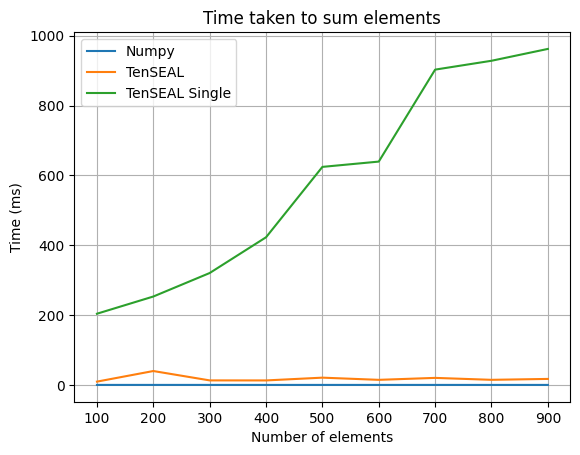

In [20]:
# test the performance of the encryption vs the numpy sum
# go from 100 to 100000 elements
# plot the time taken for each
import matplotlib.pyplot as plt

times_numpy = []
times_tenseal = []
times_tenseal_single = []

NUMBER_OF_ELEMENTS = 1000
STEPS = 100

for i in range(100, NUMBER_OF_ELEMENTS, STEPS):
    vector = np.arange(i)
    start = time.perf_counter_ns()
    sum_vector = np.sum(vector)
    stop = time.perf_counter_ns()
    times_numpy.append((stop-start)/1e6)

    start = time.perf_counter_ns()
    encrypted_vector = ts.bfv_vector(context, vector)
    # Sum the encrypted vector elements
    encrypted_sum = encrypted_vector.sum()
    # Decrypt the sum
    decrypted_sum = encrypted_sum.decrypt()
    stop = time.perf_counter_ns()
    times_tenseal.append((stop-start)/1e6)

    start = time.perf_counter_ns()
    encrypted_sum = calculate_encrypted_sum_single(vector)
    decrypted_sum = decrypt_value(encrypted_sum)
    stop = time.perf_counter_ns()
    times_tenseal_single.append((stop-start)/1e6)


plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time (ms)")
plt.title("Time taken to sum elements")



plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), times_numpy, label="Numpy")
plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), times_tenseal, label="TenSEAL")
plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), times_tenseal_single, label="TenSEAL Single")

# enable legend
plt.legend()


# Time difference between numpy and tenseal

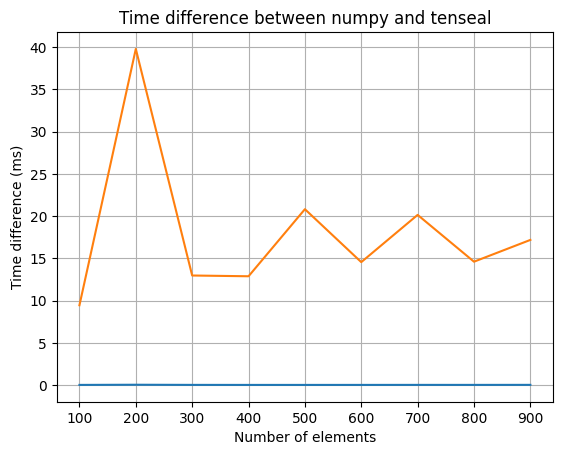

In [21]:
# only plot the time difference between numpy and tenseal and not the single sum

plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time difference (ms)")
plt.title("Time difference between numpy and tenseal")

time_diff = [numpy - tenseal for numpy, tenseal in zip(times_numpy, times_tenseal)]
#plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), time_diff, label="Numpy - TenSEAL")
plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), times_numpy, label="Numpy")
plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), times_tenseal, label="TenSEAL")

In [22]:
# calculate the average time difference

time_diff = [numpy - tenseal for numpy, tenseal in zip(times_numpy, times_tenseal)]
avg_diff = abs(sum(time_diff) / len(time_diff))
print(f"Average time difference: {avg_diff} ms")

Average time difference: 18.02542222222222 ms


# Calculate bigger encrpyted Vectors by splitting them in equal chunks

In [ ]:

vector = list(range(0, 1000, 1))
sum = calculate_encrypted_sum_multiple(vector)
print(f"Encrypted sum: {sum}")

Done with 100 elements
Done with 200 elements
Done with 300 elements
Done with 400 elements
Done with 500 elements
Done with 600 elements
Done with 700 elements
Done with 800 elements
Done with 900 elements
Done with 1000 elements
Done with 1100 elements
Done with 1200 elements
Done with 1300 elements
Done with 1400 elements
Done with 1500 elements
Done with 1600 elements
Done with 1700 elements
Done with 1800 elements
Done with 1900 elements
Done with 2000 elements
Done with 2100 elements
Done with 2200 elements
Done with 2300 elements
Done with 2400 elements
Done with 2500 elements
Done with 2600 elements
Done with 2700 elements
Done with 2800 elements
Done with 2900 elements
Done with 3000 elements
Done with 3100 elements
Done with 3200 elements
Done with 3300 elements
Done with 3400 elements
Done with 3500 elements
Done with 3600 elements
Done with 3700 elements
Done with 3800 elements
Done with 3900 elements
Done with 4000 elements
Done with 4100 elements
Done with 4200 elements
D

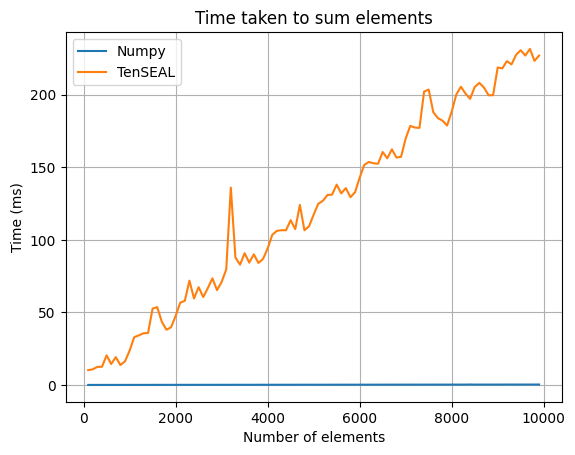

In [29]:
import matplotlib.pyplot as plt

times_numpy = []
times_tenseal = []

NUMBER_OF_ELEMENTS = 10000
STEPS = 100

for i in range(100, NUMBER_OF_ELEMENTS, STEPS):
    vector = [1 for i in range(i)]
    start = time.perf_counter_ns()
    sum_vector = np.sum(vector)
    stop = time.perf_counter_ns()
    times_numpy.append((stop-start)/1e6)

    start = time.perf_counter_ns()

    decrypted_sum = calculate_encrypted_sum_multiple(vector)
    stop = time.perf_counter_ns()
    times_tenseal.append((stop-start)/1e6)
    print(f"Done with {i} elements")



plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time (ms)")
plt.title("Time taken to sum elements")


plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), times_numpy, label="Numpy")
plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), times_tenseal, label="TenSEAL")

# enable legend
plt.legend()